In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score,recall_score,f1_score, confusion_matrix, fbeta_score 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt


df=pd.read_csv('risk_factors_cervical_cancer.csv')
df['STDs:AIDS'] = df['STDs:AIDS'].replace(['?'], '1')
df['STDs:HPV'] = df['STDs:HPV'].replace(['?'], '1')
df['STDs:cervical condylomatosis'] = df['STDs:cervical condylomatosis'].replace(['?'], '1')
df['STDs:molluscum contagiosum'] = df['STDs:molluscum contagiosum'].replace(['?'], '1')
df.replace('?', np.NaN, inplace=True)
df = df.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis = 1) #drop this columns, because they contains too much nulls

def compute_target(df):    
    if (df['Biopsy']==1) | (df['Hinselmann'] == 1) | (df['Schiller'] == 1) | (df['Citology'] == 1):
        return 1
    else:
        return 0

df['target'] = df.apply(compute_target, axis = 1)
df = df.drop(['Hinselmann', 'Schiller', 'Biopsy', 'Citology'], axis = 1)

#split dataset 80% trainning and 20% test set.
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)


train_data= train_data.fillna(train_data.median()) #replace null values with the median value of the column
test_data= test_data.fillna(test_data.median())

train_data['Age'] =( train_data['Age'] - train_data['Age'].mean() ) / train_data['Age'].std()  #standarilazation of Age
test_data['Age'] =( test_data['Age'] - test_data['Age'].mean() ) / test_data['Age'].std()

for x in list(train_data.keys()): 
    train_data[x] = train_data[x].astype('float')
    if (x!='Smokes' and x!='Smokes (packs/year)' and x!='Hormonal Contraceptives (years)' and x!='IUD (years)'): #because these columns must remain float
        train_data[x]=train_data[x].apply(np.int64)

for x in list(test_data.keys()):
    test_data[x] = test_data[x].astype('float')
    if (x!='Smokes' and x!='Smokes (packs/year)' and x!='Hormonal Contraceptives (years)' and x!='IUD (years)'): #because these columns must remain float
        test_data[x]=test_data[x].apply(np.int64)

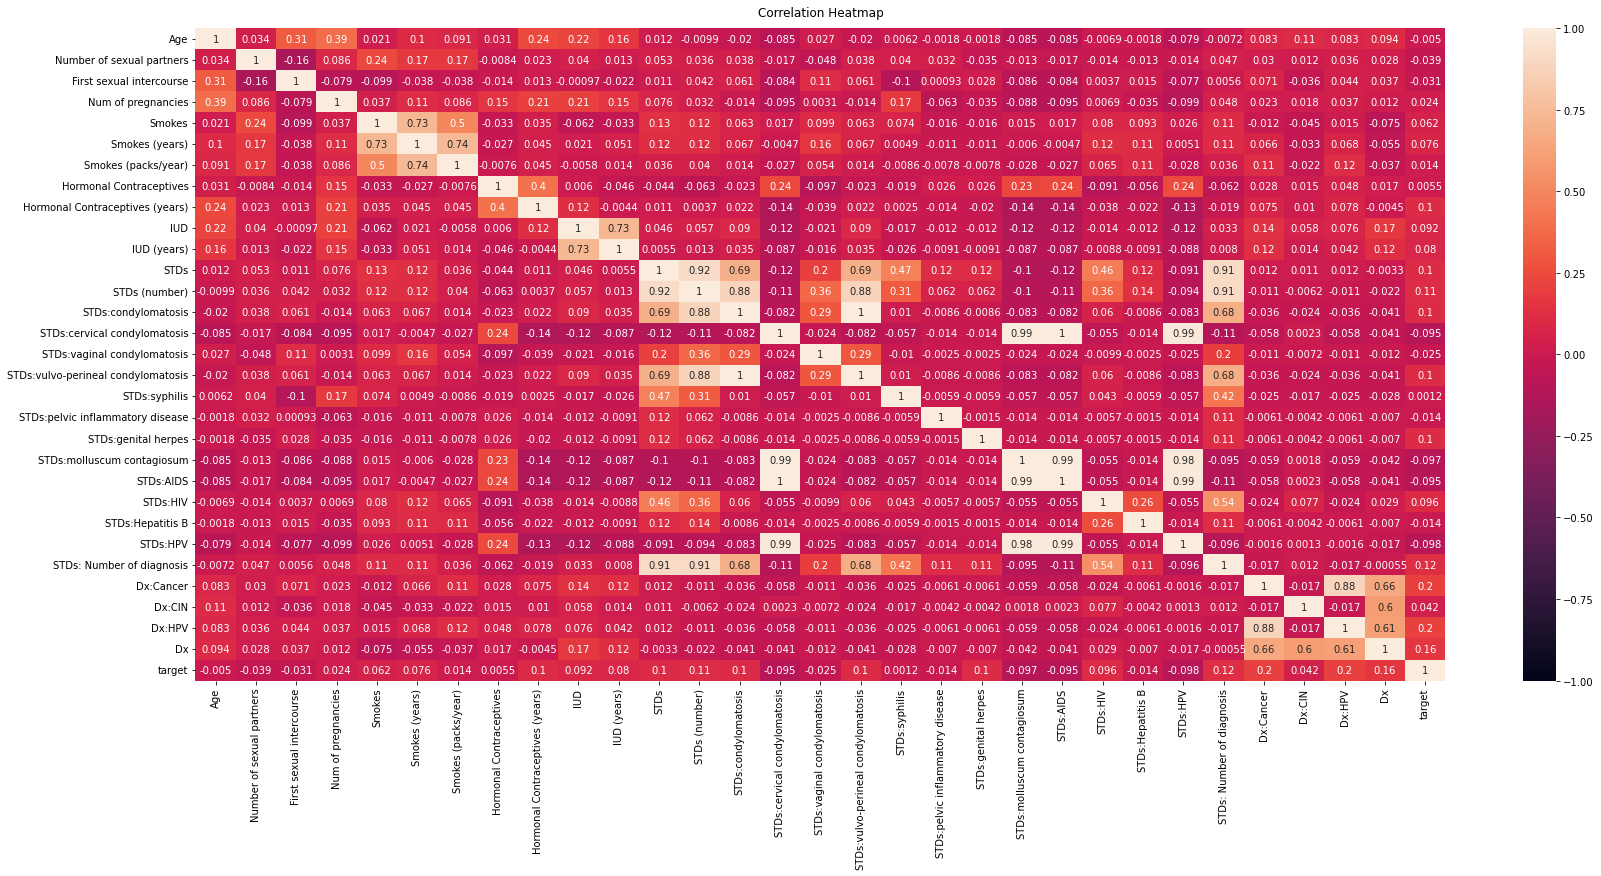

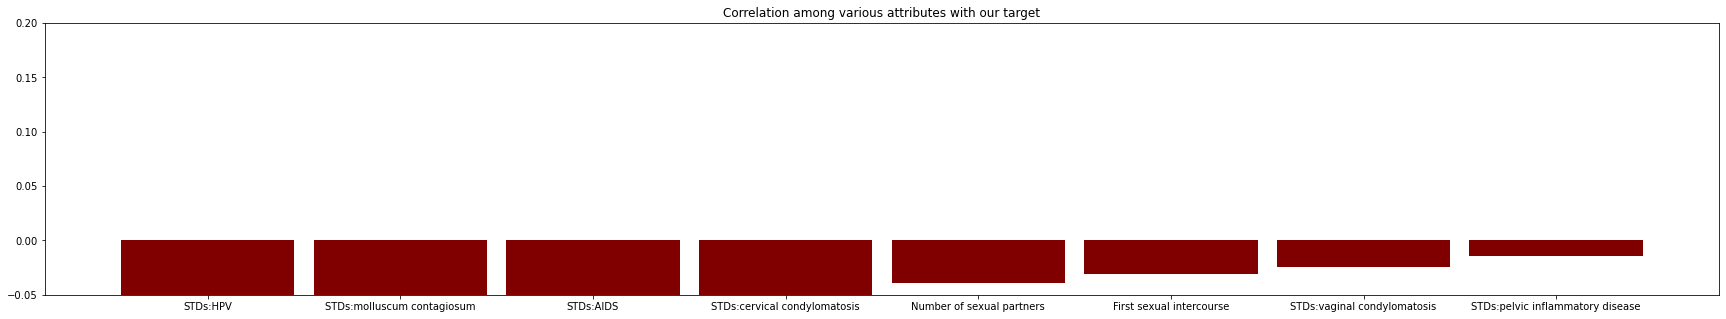

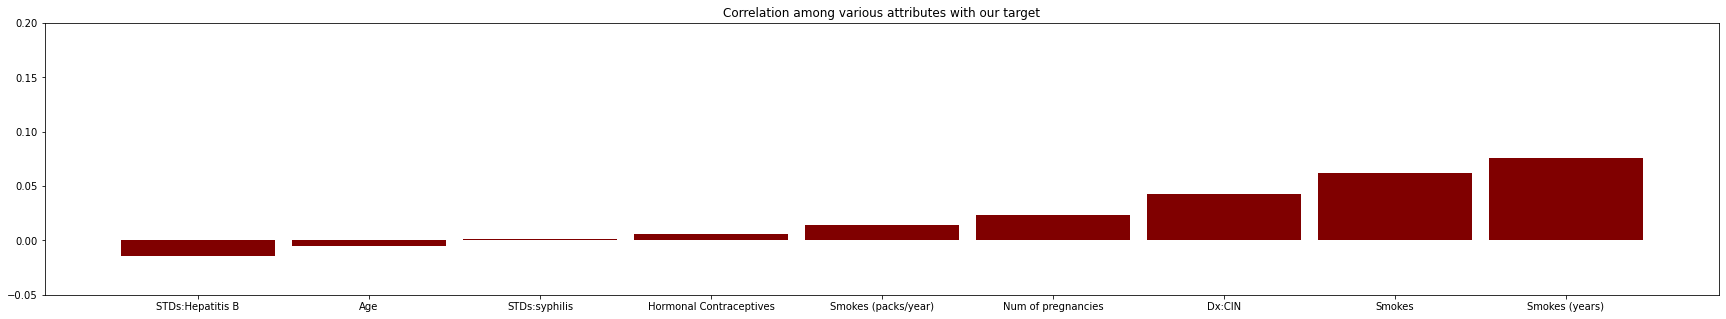

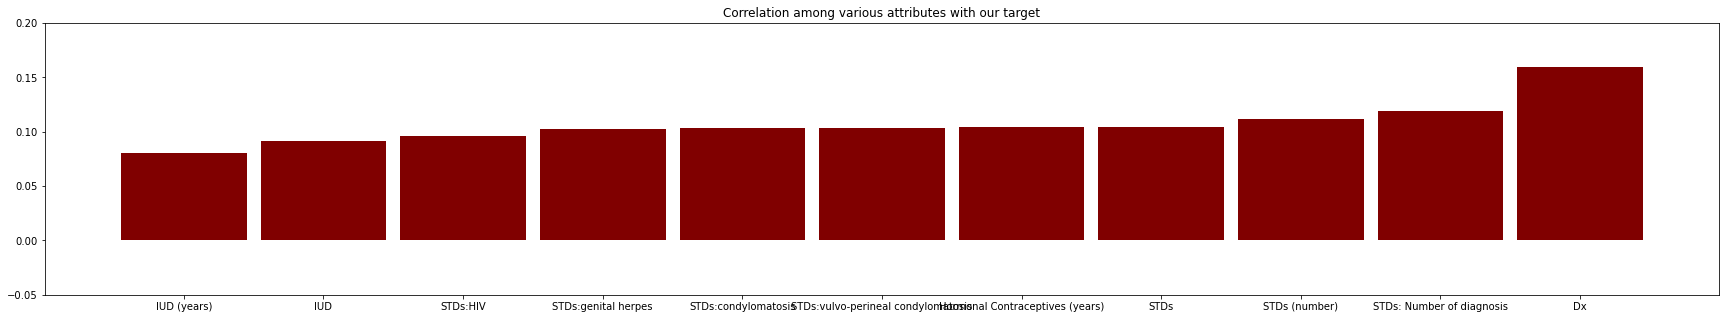

Most correlated attributes to the target in ascending order: 

                                      target
STDs:syphilis                       0.001203
Age                                 0.004996
Hormonal Contraceptives             0.005464
STDs:Hepatitis B                    0.014272
STDs:pelvic inflammatory disease    0.014272
Smokes (packs/year)                 0.014440
Num of pregnancies                  0.023705
STDs:vaginal condylomatosis         0.024757
First sexual intercourse            0.030521
Number of sexual partners           0.039406
Dx:CIN                              0.042267
Smokes                              0.061724
Smokes (years)                      0.075653
IUD (years)                         0.080073
IUD                                 0.091723
STDs:cervical condylomatosis        0.095339
STDs:AIDS                           0.095339
STDs:HIV                            0.096187
STDs:molluscum contagiosum          0.096513
STDs:HPV                            0

In [2]:
plt.figure(figsize=(28, 12))
heatmap = sns.heatmap(train_data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

#plot and see how much every variable is related to the target
#If the value is 0, there is no correlation between the two variables. This means that the variables changes in a random manner with respect to each other.
import numpy as np 
import matplotlib.pyplot as plt
df2=train_data.corr()
df3=df2['target']
df4=df3.to_frame()
df5=df4.sort_values(by=['target'])


df5a=df5.iloc[0:8]
my_keys = list(df5a.index) 
values = list(df5a['target'])
fig = plt.figure(figsize = (30, 5))
plt.bar(my_keys, values, color ='maroon', width = 0.9) 
ax = plt.gca()
ax.set_ylim([-0.05, 0.2])
plt.title("Correlation among various attributes with our target") 
plt.show()


df5b=df5.iloc[8:17]
my_keys = list(df5b.index) 
values = list(df5b['target'])

fig = plt.figure(figsize = (30, 5))

plt.bar(my_keys, values, color ='maroon', width = 0.9) 

ax = plt.gca()
ax.set_ylim([-0.05, 0.2])
plt.title("Correlation among various attributes with our target") 
plt.show()

df5c=df5.iloc[17:28]
my_keys = list(df5c.index) 
values = list(df5c['target'])

fig = plt.figure(figsize = (30, 5))

plt.bar(my_keys, values, color ='maroon', width = 0.9) 

ax = plt.gca()
ax.set_ylim([-0.05, 0.2])
plt.title("Correlation among various attributes with our target") 
plt.show()

df4['target']=abs(df4['target'])
df6=df4.sort_values(by=['target']) #sort attributes from the most unrelated to the most related

print('Most correlated attributes to the target in ascending order: ')
print('')
print(df6)

In [3]:
grid_param_rf = {
    'n_estimators': [100, 400, 800],
    'max_depth': [5, 10, 15],
}
rand_param_rf = {
    'n_estimators': np.linspace(start=1, stop=1000, num=10, dtype=int),
    'max_depth': np.linspace(start=1, stop=20, num=5, dtype=int),
}

grid_param_xgb = {
    'n_estimators': [100, 400, 800],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.20],
}
rand_param_xgb = {
    'n_estimators': np.linspace(start=1, stop=1000, num=10, dtype=int),
    'max_depth': np.linspace(start=1, stop=20, num=5, dtype=int),
    'learning_rate': [0.05, 0.1, 0,15, 0.25, 0.4],
}

def fit_and_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred_proba1 = clf.predict_proba(X_test)[:, 1] 
    y_pred_proba=np.where(y_pred_proba1>=0.2, 1, 0)# convert results to int (0 or 1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy=accuracy_score(y_test, y_pred_proba)  
    sensitivity=recall_score(y_test, y_pred_proba)
    specificity=recall_score(y_test, y_pred_proba, pos_label=0)
    f1_score_1=f1_score(y_test, y_pred_proba) #for positive values
    f1_score_0=f1_score(y_test, y_pred_proba, pos_label=0) #for negative values
    f_beta_score=fbeta_score(y_test, y_pred_proba, average='macro', beta=8.5) #not weighted
    matrix = confusion_matrix(y_test, y_pred_proba)
    return fpr, tpr, auc, accuracy, sensitivity, specificity,  f1_score_1, f1_score_0, f_beta_score, matrix


def finetune(clf, grid_param, rand_param, X, Y):

    gridClassifier = GridSearchCV(clf, grid_param, cv=2, scoring='recall') #scoring 
    gridClassifier.fit(X, Y)
    grid_best = gridClassifier.best_params_

    randomClassifier = RandomizedSearchCV(clf, rand_param, n_iter=50, cv=2, scoring='recall') #scoring='roc_auc'
    randomClassifier.fit(X, Y)
    rand_best = randomClassifier.best_params_

    return grid_best, rand_best

In [4]:
#cross validation function for evaluation of our models
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer

def cross_validation(model, _X, _y, _cv=5):
    def true_negatives(y_true, y_pred):
        return sum((y_true == 0) & (y_pred == 0))

    def false_positives(y_true, y_pred):
        return sum((y_true == 0) & (y_pred == 1))

    true_negatives_scorer = make_scorer(true_negatives)
    false_positives_scorer = make_scorer(false_positives)
    fbeta_scorer = make_scorer(fbeta_score, beta=8.5)
    f1_scorer_0=make_scorer(f1_score,pos_label=0)
    
    _scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1',
    'f1_score(0)': f1_scorer_0,   
    'fbeta_score': fbeta_scorer,
    'true_negatives': true_negatives_scorer,
    'false_positives': false_positives_scorer
}
    results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
    print(    
              "Mean Validation roc_auc:             " , results['test_roc_auc'].mean(),
              "\nMean Validation Accuracy:            " , results['test_accuracy'].mean(),
              "\nMean Validation Sensitivity(Recall): " , results['test_recall'].mean(),
              "\nMean Validation Specificity:         " , (results['test_true_negatives'].sum()/(results['test_true_negatives'].sum()+results['test_false_positives'].sum())),
              "\nMean Validation F1_score(0):         ", results['test_f1_score(0)'].mean(),      
              "\nMean Validation F1_score(1):         ",results['test_f1'].mean(),
              "\nMean Validation fbeta_score:        ", results['test_fbeta_score'].mean()
              
      )

In [5]:
#PREDICTION WITH PCA (dimensionality reduction)

print( "\033[1m" + '\n Predict using PCA technique in feature selection: ' + "\033[0m")

#Apply SMOTETomek (oversampling + undersampling Method) after splitting the dataset. Because we do not need to change the test set data, we just need to balance the train data set, so that our model won't be biased
X_train=train_data.drop(['target'], axis = 1).values
y_train=train_data['target'].values
counter = Counter(y_train)
print('\nBefore oversampling: ',counter)

# data = {'0':counter[0], '1':counter[1], }
# courses = list(data.keys())
# values = list(data.values())
# fig = plt.figure(figsize = (5, 5))
# plt.bar(courses, values, color ='maroon', width = 0.5)
# plt.xlabel("Value")
# plt.ylabel("No. of samples")
# plt.show()

oversample_undersample = SMOTETomek(random_state=2)
X_train, y_train = oversample_undersample.fit_resample(X_train, y_train)
counter = Counter(y_train)
print('After  oversampling and undersampling: ',counter)
# data = {'0':counter[0], '1':counter[1], }
# courses = list(data.keys())
# values = list(data.values())
# fig = plt.figure(figsize = (5, 5))
# plt.bar(courses, values, color ='maroon', width = 0.5)
# plt.xlabel("Value")
# plt.ylabel("No. of samples")
# plt.show()



#Scaled the data and then use PCA method for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

y_test = test_data['target']
x_test = test_data.drop(['target'], axis = 1).values
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(0.95) # initiate PCA and classifier
X_train_transformed = pca.fit_transform(X_train_scaled) # transform / fit PCA
print('Number of new features after PCA: ',X_train_transformed.shape[1])

x_test_scaled = scaler.transform(x_test)  #only transform the test data using already fitted scaler
x_test_transformed = pca.transform(x_test_scaled) # transform new data using already fitted pca (don't re-fit the pca)
#------------------------------------------------------------------------------------------
rf = RandomForestClassifier(max_depth=5, random_state=0)

print("\nRandom Forest without CV: ")
rf_grid_best, rf_rand_best = finetune(rf, grid_param_rf, rand_param_rf, X_train_transformed, y_train)
print("Random Forest: Best GridSearchCV params: ", rf_grid_best, " and best RandomizedSearchCV params:", rf_rand_best)
rf_fpr, rf_tpr, rf_auc, rf_accuracy, rf_sensitivity, rf_specificity, rf_f1_score_1, rf_f1_score_0,f_beta_score,rf_matrix = fit_and_evaluate( 
    RandomForestClassifier(random_state=0, n_estimators=rf_rand_best["n_estimators"], max_depth=rf_rand_best["max_depth"]),
    X_train_transformed, y_train, x_test_transformed, y_test)

print('\nrf_auc: ',rf_auc,'\nrf_accuracy: ',rf_accuracy, '\nrf_sensitivity(recall): ', rf_sensitivity, '\nrf_specificity: ', rf_specificity, '\nrf_f1_score(0): ', rf_f1_score_0, '\nrf_f1_score(1): ', rf_f1_score_1, '\nrf_f_beta_score: ',f_beta_score)
print("TN:",rf_matrix[0][0],"FP:",rf_matrix[0][1],"FN:",rf_matrix[1][0],"TP:",rf_matrix[1][1])
print('\n')

print("Random Forest with CV: ")
rf_result = cross_validation(rf, X_train_transformed, y_train, 5)



xgb = XGBClassifier(random_state=0)

print("\nXGBClassifier without CV: ")
xgb_grid_best, xgb_rand_best = finetune(xgb, grid_param_xgb, rand_param_xgb, X_train_transformed, y_train)
print("XGB: Best GridSearchCV params: ", xgb_grid_best, " and best RandomizedSearchCV params:", xgb_rand_best)

xgb_fpr, xgb_tpr, xgb_auc, xgb_accuracy, xgb_sensitivity, xgb_specificity, xgb_f1_score_1, xgb_f1_score_0, f_beta_score, xgb_matrix = fit_and_evaluate(  
    XGBClassifier(random_state=0, n_estimators=xgb_rand_best["n_estimators"], max_depth=xgb_rand_best["max_depth"]),
    X_train_transformed, y_train, x_test_transformed, y_test)

print('xgb_auc: ',xgb_auc,'\nxgb_accuracy: ',xgb_accuracy, '\nxgb_sensitivity(recall): ', xgb_sensitivity, '\nxgb_specificity: ', xgb_specificity, '\nxgb_f1_score(0): ', xgb_f1_score_0, '\nxgb_f1_score(1): ', xgb_f1_score_1, '\nxgb_f_beta_score: ', f_beta_score )
print("TN:",xgb_matrix[0][0],"FP:",xgb_matrix[0][1],"FN:",xgb_matrix[1][0],"TP:",xgb_matrix[1][1])

print("\nXGBClassifier with CV: ")
xgb_result = cross_validation(xgb, X_train_transformed, y_train, 5)
print('\n')


 Predict using PCA technique: 

Before oversampling:  Counter({0: 602, 1: 84})
After  oversampling and undersampling:  Counter({0: 596, 1: 596})
Number of new features after PCA:  17

Random Forest without CV: 
Random Forest: Best GridSearchCV params:  {'max_depth': 10, 'n_estimators': 400}  and best RandomizedSearchCV params: {'n_estimators': 445, 'max_depth': 20}

rf_auc:  0.6565656565656565 
rf_accuracy:  0.6046511627906976 
rf_sensitivity(recall):  0.7222222222222222 
rf_specificity:  0.5909090909090909 
rf_f1_score(0):  0.7280000000000001 
rf_f1_score(1):  0.2765957446808511 
rf_f_beta_score:  0.6428768972093628
TN: 91 FP: 63 FN: 5 TP: 13


Random Forest with CV: 
Mean Validation roc_auc:              0.853729079867241 
Mean Validation Accuracy:             0.769325973067051 
Mean Validation Sensitivity(Recall):  0.843921568627451 
Mean Validation Specificity:          0.6946308724832215 
Mean Validation F1_score(0):          0.7499231686313654 
Mean Validation F1_score(1):      

In [6]:
#PREDICTION WITHOUT PCA. But we drop the most unrelated attributes
print( "\033[1m" + '\n Predict without PCA technique in feature selection: ' + "\033[0m")


#drop the most unrelated attributes
train_data = train_data.drop(['STDs:syphilis', 'Smokes (packs/year)', 'STDs:pelvic inflammatory disease', 'STDs:Hepatitis B'], axis = 1)
test_data = test_data.drop(['STDs:syphilis', 'Smokes (packs/year)', 'STDs:pelvic inflammatory disease', 'STDs:Hepatitis B'], axis = 1)

#drop additional attributes (see report)
train_data = train_data.drop(['STDs','STDs:vulvo-perineal condylomatosis',  'STDs: Number of diagnosis'], axis = 1)
test_data = test_data.drop(['STDs','STDs:vulvo-perineal condylomatosis', 'STDs: Number of diagnosis'], axis = 1)

#Apply SMOTETomek (oversampling + undersampling Method) after splitting the dataset. Because we do not need to change the test set data, we just need to balance the train data set, so that our model won't be biased
X_train=train_data.drop(['target'], axis = 1).values
y_train=train_data['target'].values
counter = Counter(y_train)
print('\nBefore oversampling: ',counter)
# data = {'0':counter[0], '1':counter[1], }
# courses = list(data.keys())
# values = list(data.values())
# fig = plt.figure(figsize = (5, 5))
# plt.bar(courses, values, color ='maroon', width = 0.5)
# plt.xlabel("Value")
# plt.ylabel("No. of samples")
# plt.show()

oversample_undersample = SMOTETomek(random_state=2)
X_train, y_train = oversample_undersample.fit_resample(X_train, y_train)
counter = Counter(y_train)
print('After  oversampling and undersampling: ',counter)
# data = {'0':counter[0], '1':counter[1], }
# courses = list(data.keys())
# values = list(data.values())
# fig = plt.figure(figsize = (5, 5))
# plt.bar(courses, values, color ='maroon', width = 0.5)
# plt.xlabel("Value")
# plt.ylabel("No. of samples")
# plt.show()

y_test = test_data['target']
x_test = test_data.drop(['target'], axis = 1).values

#---------------------------

rf = RandomForestClassifier(max_depth=5, random_state=0)

print("\nRandom Forest without CV: ")
rf_grid_best, rf_rand_best = finetune(rf, grid_param_rf, rand_param_rf, X_train, y_train)
print("Random Forest: Best GridSearchCV params: ", rf_grid_best, " and best RandomizedSearchCV params:", rf_rand_best)
rf_fpr, rf_tpr, rf_auc, rf_accuracy, rf_sensitivity, rf_specificity, rf_f1_score_1, rf_f1_score_0,f_beta_score,rf_matrix = fit_and_evaluate(
    RandomForestClassifier(random_state=0, n_estimators=rf_rand_best["n_estimators"], max_depth=rf_rand_best["max_depth"]),
    X_train, y_train, x_test, y_test)
print('rf_auc: ',rf_auc,'\nrf_accuracy: ',rf_accuracy, '\nrf_sensitivity (recall): ', rf_sensitivity, '\nrf_specificity: ', rf_specificity, '\nrf_f1_score(0): ', rf_f1_score_0, '\nrf_f1_score(1): ', rf_f1_score_1, '\nrf_f_beta_score: ', f_beta_score)
print("TN:",rf_matrix[0][0],"FP:",rf_matrix[0][1],"FN:",rf_matrix[1][0],"TP:",rf_matrix[1][1])


print("\nRandom Forest with CV: ")
rf_result = cross_validation(rf, X_train, y_train, 5)

#-------
xgb = XGBClassifier(random_state=0)

print("\nXGBClassifier without CV: ")
xgb_grid_best, xgb_rand_best = finetune(xgb, grid_param_xgb, rand_param_xgb, X_train, y_train)
print("XGB: Best GridSearchCV params: ", xgb_grid_best, " and best RandomizedSearchCV params:", xgb_rand_best)
xgb_fpr, xgb_tpr, xgb_auc, xgb_accuracy, xgb_sensitivity, xgb_specificity, xgb_f1_score_1, xgb_f1_score_0,f_beta_score, xgb_matrix = fit_and_evaluate(
    XGBClassifier(random_state=0, n_estimators=xgb_rand_best["n_estimators"], max_depth=xgb_rand_best["max_depth"]),
    X_train, y_train, x_test, y_test)
print('xgb_auc: ',xgb_auc,'\nxgb_accuracy: ',xgb_accuracy, '\nxgb_sensitivity (recall): ', xgb_sensitivity, '\nxgb_specificity: ', xgb_specificity, '\nxgb_f1_score(0): ', xgb_f1_score_0, '\nxgb_f1_score(1): ', xgb_f1_score_1, '\nxgb_f_beta_score: ', f_beta_score )
print("TN:",xgb_matrix[0][0],"FP:",xgb_matrix[0][1],"FN:",xgb_matrix[1][0],"TP:",xgb_matrix[1][1])


print("\nXGBClassifier with CV: ")
xgb_result = cross_validation(xgb, X_train, y_train, 5)



 Predict without PCA technique: 

Before oversampling:  Counter({0: 602, 1: 84})
After  oversampling and undersampling:  Counter({0: 593, 1: 593})

Random Forest without CV: 
Random Forest: Best GridSearchCV params:  {'max_depth': 15, 'n_estimators': 100}  and best RandomizedSearchCV params: {'n_estimators': 667, 'max_depth': 20}
rf_auc:  0.6562049062049062 
rf_accuracy:  0.6918604651162791 
rf_sensitivity (recall):  0.6111111111111112 
rf_specificity:  0.7012987012987013 
rf_f1_score(0):  0.8029739776951673 
rf_f1_score(1):  0.29333333333333333 
rf_f_beta_score:  0.6486430181051877
TN: 108 FP: 46 FN: 7 TP: 11

Random Forest with CV: 
Mean Validation roc_auc:              0.8837299625732646 
Mean Validation Accuracy:             0.7926745381696982 
Mean Validation Sensitivity(Recall):  0.7269477282438399 
Mean Validation Specificity:          0.8583473861720068 
Mean Validation F1_score(0):          0.8076750792876352 
Mean Validation F1_score(1):          0.772355842549876 
Mean Vali